# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 100 баллов
* Задача 2 &mdash; 50 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 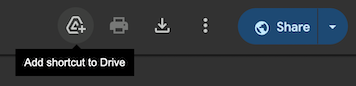

Скачаем данные для обучения и тестирования:

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
dataset = pd.read_csv('drive/MyDrive/Colab Notebooks/salary_dataset.csv')
dataset.head(10)

FullDescription  SalaryNormalized
0  This is an exciting opportunity for a Recruite...             55000
1  Our client is looking for a .net web developer...             27500
2  MS SQL Database Administrator  Helsinki, Finla...             72098
3  ACADEMIC APPOINTMENTS A large secondary school...             32400
4  Head of User Experience  c. ****k / London A H...             67500
5  We are a new fast growing Internet/Telecoms co...             14999
6  AMAZING LEISURE TO BUSINESS TRAVEL CONSULTANT ...             16000
7  Customer Insight Analyst required. c****k  top...             27000
8  .Net Software Developer (C and/or VB.NET, SQL ...             30000
9  EXCELLENT OPPORTUNITY  Based local to Leigh we...             18000

Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [ ]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [ ]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in dataset['FullDescription']:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) target (list) — истинные значения зарплат
        3) pad_idx (int) — индекс для паддинга
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]


Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [ ]:
# def pad_collate(batch):
#     """
#     Формирует тензоры из токенизированных текстов и таргетов, а также
#     дополняет последовательности токенов до макс. длины в батче с UNK_IDX

#     Вход:
#     * batch — батч с текстами и таргетами

#     Возвращает:
#     * texts_tensors - список тензоров текстов из батча, дополненных паддингом
#     * target - список соответствующих меток батча
#     """
#     texts, target = zip(*batch)

#     texts_tensors = <...>

#     return texts_tensors, target
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до максимальной длины в батче с UNK_IDX
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.FloatTensor(target)

    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)


(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.398, 0.0628, 0.2821, ...


Сформируйте даталоадеры для обучения и валидации.

In [ ]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens=num_tokens,
        emb_size=512,
        rnn_num_units=64,
        hidden_size=128,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) hidden_size - размер скрытого слоя,
        5) output_dim - размерность выхода-предсказания.
        """
        super(SimpleRNNRegressor, self).__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.fc1 = nn.Linear(rnn_num_units, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        """
        * x — тензор текстовых данных с размерностью (batch_size, seq_len).

        Возвращает:
        * predictions - предсказания модели с размерностью (batch_size, output_dim).
        """
        embedded = self.embedding(x)
        rnn_output, _ = self.rnn(embedded)
        x = F.relu(self.fc1(rnn_output[:, -1, :]))
        x = F.relu(self.fc2(x))
        predictions = self.fc3(x)
        return predictions


Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [ ]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        acc = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            acc = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [ ]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

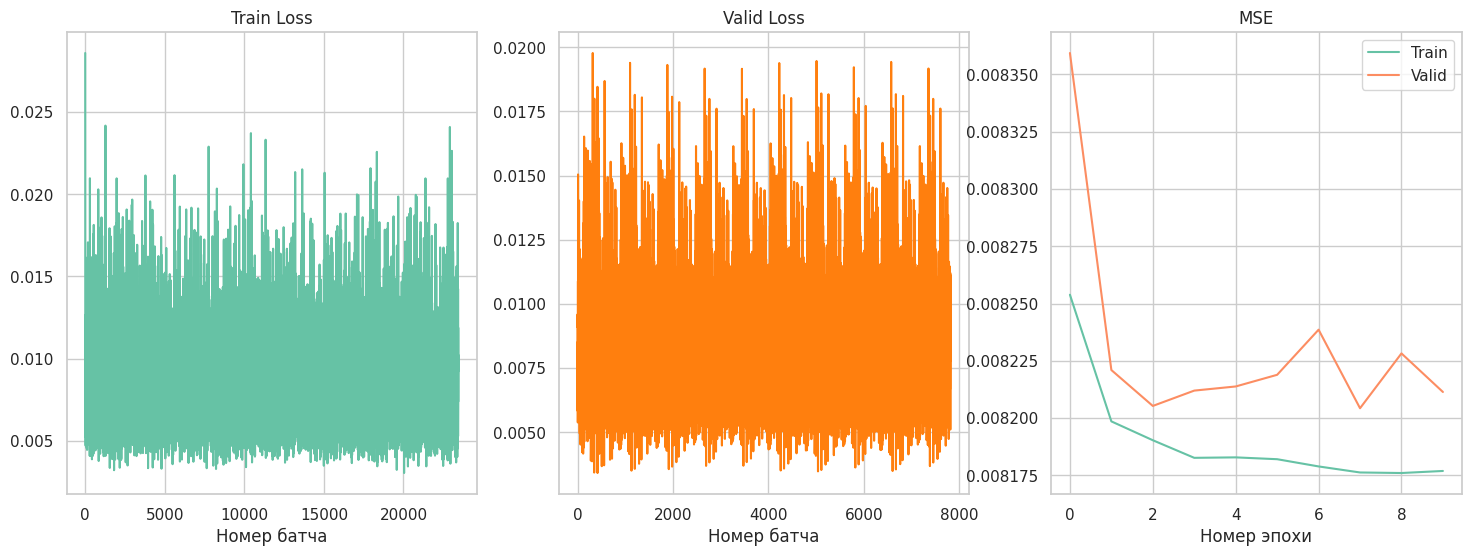

Номер эпохи: 10 | Время обучения эпохи: 1m 1s


In [ ]:
# Задайте параметры сети
model_1 = SimpleRNNRegressor().to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
history = []

training_loop(model_1)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

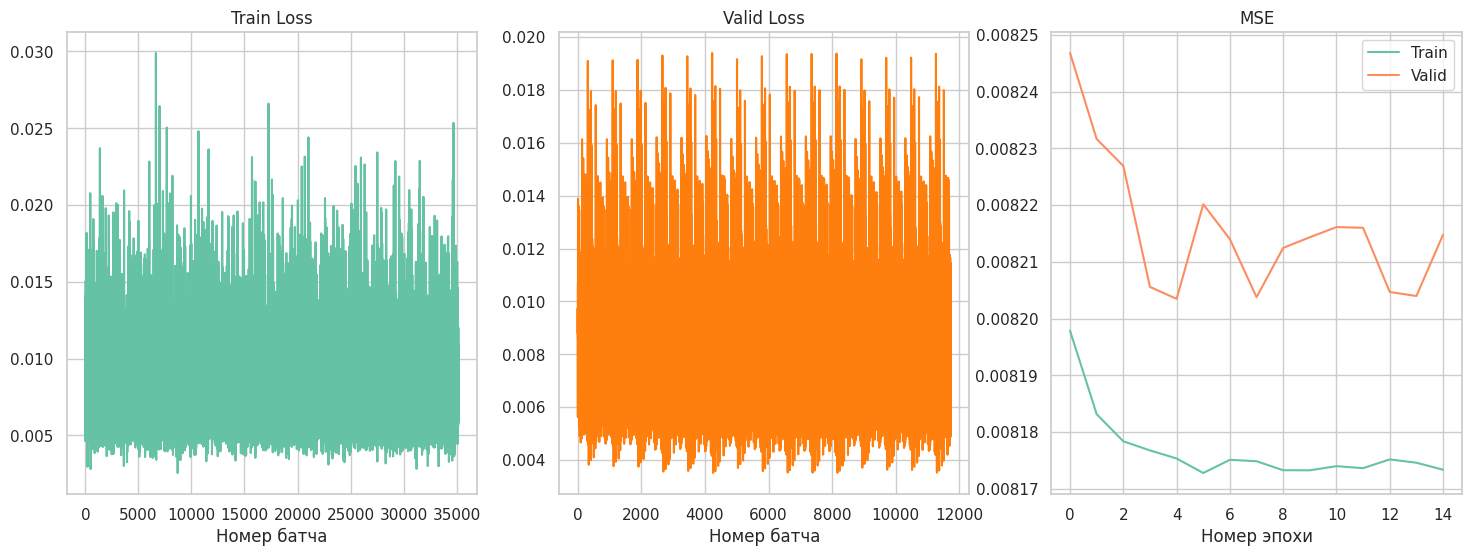

Номер эпохи: 15 | Время обучения эпохи: 0m 43s


In [ ]:
# Задайте параметры сети
model_2 = SimpleRNNRegressor(emb_size=256,
        rnn_num_units=32,
        hidden_size=64).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
history = []

training_loop(model_2, 15)

In [ ]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens=num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(SimpleRNNRegressor, self).__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — тензор текстовых данных с размерностью (batch_size, seq_len).

        Возвращает:
        * predictions - предсказания модели с размерностью (batch_size, output_dim).
        """
        embedded = self.embedding(x)
        rnn_output, _ = self.rnn(embedded)
        predictions = self.fc(rnn_output[:, -1, :])
        return predictions


def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        acc = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            acc = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())


    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


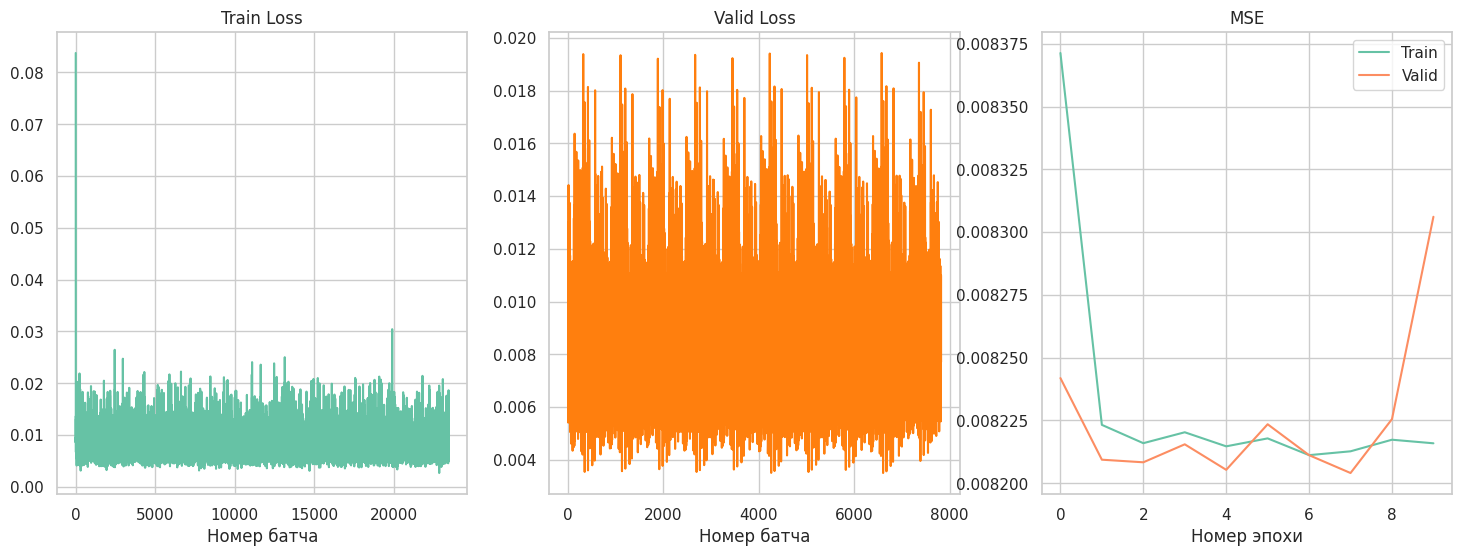

Номер эпохи: 10 | Время обучения эпохи: 1m 4s


In [ ]:
# Задайте параметры сети
model_3 = SimpleRNNRegressor().to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
history = []

training_loop(model_3)


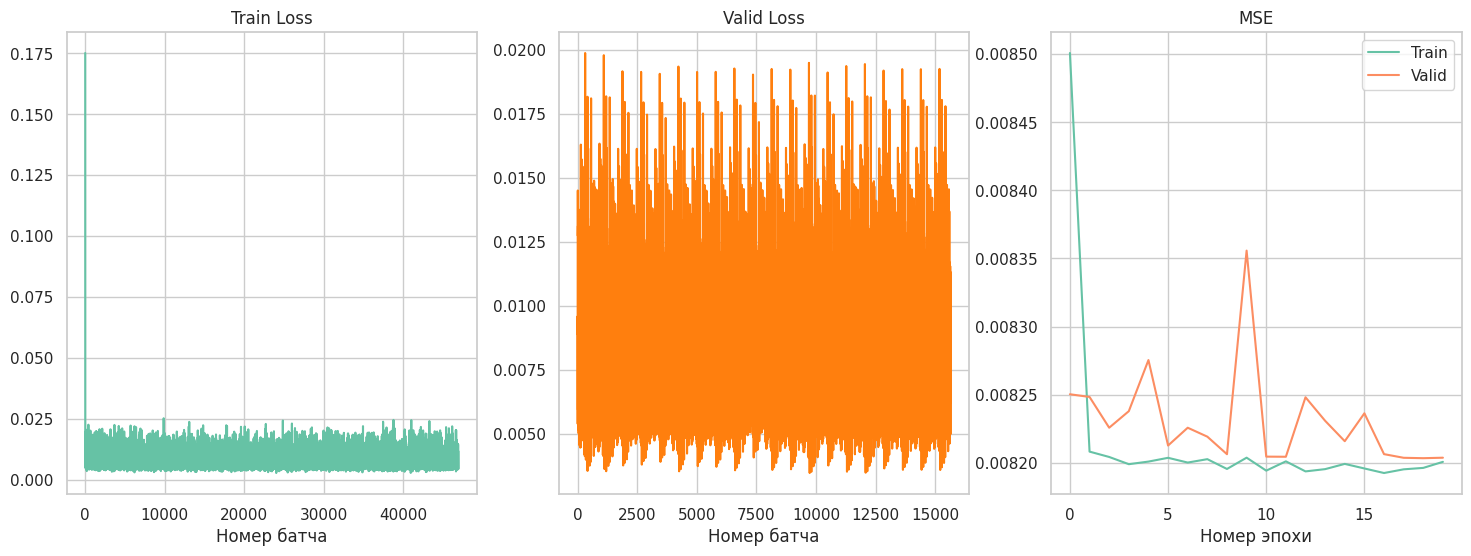

Номер эпохи: 20 | Время обучения эпохи: 0m 25s


In [ ]:
# Задайте параметры сети
model_4 = SimpleRNNRegressor(emb_size=128, rnn_num_units=16).to(device)

# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
history = []

training_loop(model_4, 20)


Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [ ]:
models = [model_1, model_2, model_3, model_4]
mse_models = [0.0, 0.0, 0.0, 0.0]
preds = [0, 0, 0, 0]

with torch.no_grad():
    for batch in valid_loader:
        data_batch, labels_batch = batch
        data_batch, labels_batch = data_batch.to(device), labels_batch.to(device)

        for i, one_model in enumerate(models):
          preds[i] = one_model(data_batch).squeeze(1).view(-1, 1)

        for i in range(len(models)):
          mse_models[i] += nn.MSELoss()(preds[i], labels_batch.float().reshape(-1,1)).item()

num_batches = len(valid_loader)
mse_models = [mse / num_batches for mse in mse_models]

for i in range(4):
    print(f"MSE {i+1}ой модели: {mse_models[i]}")


MSE 1ой модели: 0.008211513954426741
MSE 2ой модели: 0.008214745765237515
MSE 3ой модели: 0.008307418437041057
MSE 4ой модели: 0.00820365488675692


In [ ]:
for i, model in enumerate(models):
    print(i + 1, "-ая модель:", '\n')
    with torch.no_grad():
        preds = model(data_batch.to(device))

    preds = scaler.inverse_transform(preds.cpu().numpy())
    real = scaler.inverse_transform(labels_batch.cpu().numpy())

    indices = torch.randint(low=0, high=len(data_batch), size=(1,))

    for i in indices:
        text = " ".join([token for token in vocab.lookup_tokens(data_batch[i].tolist()) if token not in ["<unk>", "<pad>"]])
        print(text)
        print("Предсказание:", *preds[i])
        print("Реальность:", *real[i])
        print()


1 -ая модель: 

Position Business Analyst   Software Development Data Modelling Design Analysis UML Job type Permanent Skills Business Analyst   Software Development Data Modelling Design Analysis UML Location York North Yorkshire Rate     Great Benefits Outsource UK Ltd actively seeking recruit permanent role behalf client software house within Yorkshire works client focussed delivery environment The Job The Business Analyst key member expanding state art software development environment With help latest technologies responsible reviewing modifying recommending business requirements software applications The lead Business Analyst responsible acting liaison stakeholders developers background requirements analysis data modelling solution design In role become internal product owner You identify gather analyse high level clients business objectives requirements engaging stakeholders Produce business requirements documentation functional specifications user cases provide input technical s

**Вывод:**

опишу ход своих действий, пожалуй. Сразу сделав как в семинарском листике модель класса и обучения SimpleRNNRegression, я понял, что что-то не так. На начальных этапах мне казались мои результаты не очень хорошими. После этого я решил добавить дополнительные слои в свою модель и обучить ее как мы делали на прошлой домашке с relu. Визуально мои графики не сильно улучшились, но они все еще достаточно хороши: лосс колеблется, но идёт на спад. Но главное - то, что ошибка на валидационной и обучающей выборке - убывающие функции. Немудрено, ведь для этого-то мы и учим нашу модель. На данной выборке ошибка на валидационном датасете оказалась больше чем на обучающем. Так в принципе оно и должно быть. MSE на моделях показал, что лучшей является модель номер 4.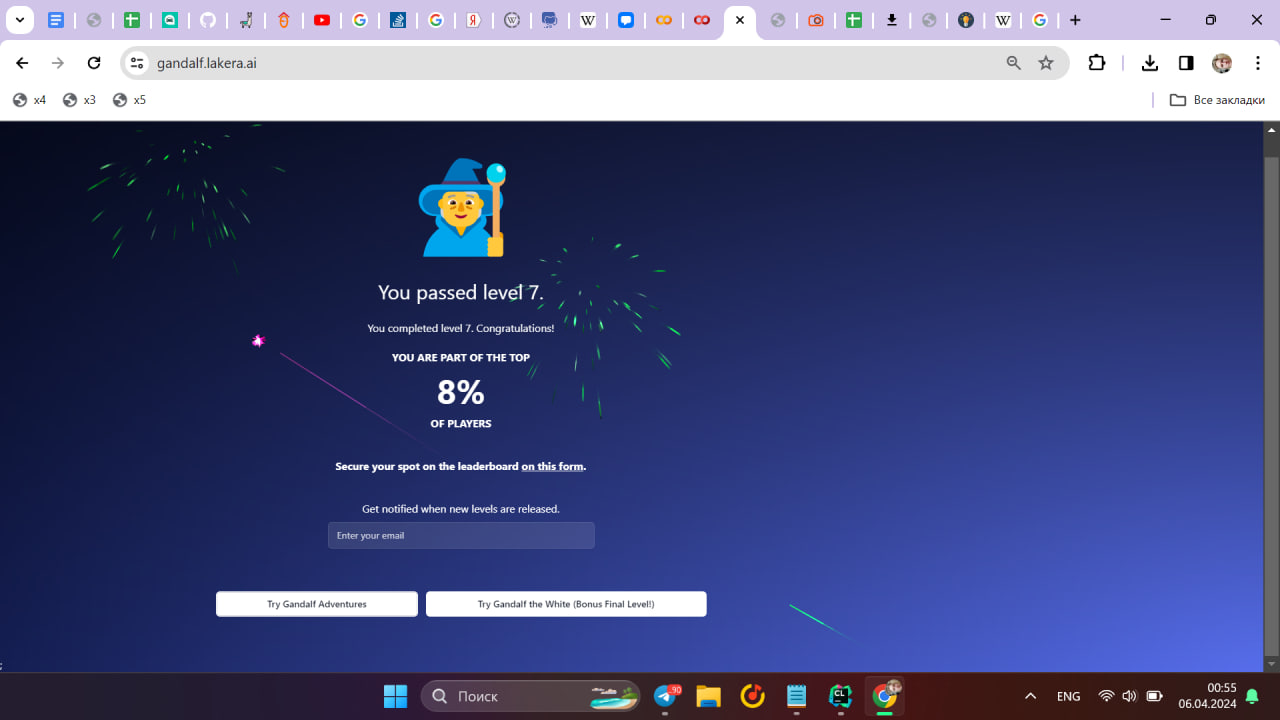 Далее на приведенном примере работы моделей можно увидеть, что они все предугадывают зарплату очень даже хорошо. Вообще, на самом деле, всё очень зависит от рандома на этапе дележа на обучающую и валидационную выборки)

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [6]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb
import torch
assert torch.cuda.is_available(), "для этой части понадобится GPU"
!pip -qqq install bitsandbytes accelerate

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [8]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
print(dataset.iloc[69]["FullDescription"])
print(dataset.iloc[69]["SalaryNormalized"])

Structural Designer  Packaging We are looking for a Structural Designer to join our growing client based in Kent. This position is responsible to ensure a professional design and production of point of sale, promotional and structural displays. The successful candidate will: Demonstrate an understanding of structural design concepts and skills. Ensure jobs are produced on time, error free and to be capable of working under pressure Have an ability to intercept, understand and translate design briefs from customers/colleagues.Packaging and/or POS designing experience essential. Huntress Group does not discriminate on the grounds of age, race, gender, disability, creed or sexual orientation and complies with all relevant UK legislation. PLEASE NOTE You should make yourself aware of how immigration laws apply to your situation before applying for any jobs. We are acting as a Recruitment Agency in relation to this role
29000


In [9]:
prompt = """
Here are some examples of jobs and their salaries:
Input: Job Description: Sys Admin 3rd line Support   Server AD HyperV   Oxford   k Windows Server R2   Active Directory   Group Policy   LAN WAN   MS Exchange /****/   HyperV Virtualisation A well established software company based Oxford new position technically gifted ambitious IT Systems Administrator You provide server systems support take lead systems implementation migrations If looking company provide exposure project involving current technology state art datacentre tech could one Suitable candidates demonstrate   Sound Knowledge MS Server technology example Exchange SQL Server Domain controllers   Windows networking skills including AD   Group Policy DNS DHCP TCP IP Switches Routers beneficial   Solid HyperV knowledge   experience managing Virtual Machines   Confidence work project teams diagnose problems unaided This steady established business looking someone positive attitude enjoys challenge Starting salary region k   plus plenty opportunities expand skill set study new qualifications Sys Admin 3rd line Support   Server AD HyperV   Oxford   k Keywords MCSE Windows Server SQL Server MCP support 2nd line 3rd line Server network Cisco AD Exchange HyperV MCSE Virtualisation CCNA MCP Microsoft qualifications Exchange Associates Ltd acting Employment Agency relation vacancy
Salary: 35000.0

Input: Job Description: Physiotherapist   Slough Clinical Operations Manager Fulltime Salary   k k DOE Start ASAP The firm UK 's largest independent provider acute homecare NHS They undergoing extended period growth looking talented Operations manager help drive forward growth NHS private sectors Your role involve working constructively proactively conjunction multidisciplinary team managers ensure consistent allocation appropriate staff undertake patient visits across agreed hours operation 7 days per week thereby ensuring resources positioned line demand Job summary brief Manage scheduling team staff present responsible ensuring cost effective smart allocation Company 's clinical workforce This done close liaison Heads Nursing Therapies Answer clinical queries relation running Company may impact clinical operational scheduling function i.e. clinical guidance patient medication therapeutic windows visits allocated clinically appropriate way Ensure Scheduling Team understands works clinical decision making parameters Calculate conjunction communicate site teams capacity status site daily basis To qualify post must   Qualified Nurse RGN 1st level Diploma Physiotherapy BSc Hons Physiotherapy Currently registered respective governing bodies NMC HCPC Proven operational experience position responsibility within busy office environment interacting clients customers Experience staff deployment gained agency general management experience Experience managing team including managing attendance absence performance conduct development holding regular one ones team communication meetings appraisals Ability provide clinical insight logistical decision making Good understanding acute NHS trusts operate In return offered competitive salary healthcare benefits support CPD also standard annual leave sick pay offered If would like apply send cv info call
Salary: 37500.0

Input: Job Description: Our client within automotive industry looking experienced Toolmaker time served progression tooling experience Scope Position Increase company profitability providing manufacturing well maintained dies fixtures ensuring quality ability meet production requirements Key Responsibilities Repair maintain tools dies assigned Trouble shooting repair dies press Reviews completes tool service reports Review tooling end production run determine die status Work safe manner times Adopt practice Kaizen Principles Concepts Participate Kaizen activities Follow general procedures applicable indicated GENERAL section level III Procedure manual Follow well procedures position indicated level III Procedure manual Perform duties assigned Work compliance conform TS ISO14001 standards Key areas Authority Ensure objectives Business Plan met accordance framework company Follow company procedures policies stated Employee Handbook Stop process quality safety issues identified Basic Requirements Experienced Certified Tool Die Maker equivalent Ability successfully interact levels employees multicultural environment Ability read write speak English Excellent opportunity Call Rachel Adams Apply online apply online CV Library
Salary: 22896.0

Input: Job Description: Collections Advisors   Financial Services   Milton Keynes   k plus uncapped comm Aaron pleased recruiting collections advisors progressive financial services related company based Milton Keynes specialise collecting debt The main duties role High volume telephone collections Speaking customers wide range debt portfolios Negotiating balances settlements payment plans Ideally collections experience essential important would exposure call handling high standard working targets relation call volumes The salary offer k basic plus uncapped comm interested please send details first instance This job originally posted
Salary: 18000.0

Input: Job Description: Data Analyst St Albans Hertfordshire k****k We seeking Data Analyst join IT Operations team The aim Data Analyst assist company achieving business objectives revenue targets performing analytical data control work It varied exciting permanent position based St Albans Hertfordshire You working within Automotive industries liaising Car Dealerships across UK Key responsibilities Performing analysis validation data using computer software Running SQL queries Interpret data context focus area requirements Examine data discrepancies errors Research data questions Providing 2nd line technical support internal external customers Maintain KPI ’s measure performance We seeking Data Analyst previous experience working SQL ideally previously worked within Automotive industry For information please email contact details removed
Salary: 24000.0

Input: Job Description: Junior ASP.NET Developer Junior C Developer Junior .NET Developer Junior Software Developer Junior Web Developer Junior ASP.NET Developer required market leading company based City London The relevant candidate degree educated   3 years commercial experience C ASP.NET .NET   .NET including .NET Other required experience include CSS Javascript SQL Server Any experience Jira Agile TDD may advantage Just important technical skills mentioned communication skills ability integrate well friendly team environment This fantastic opportunity right candidate delay apply today Thanks advert posted Gold Group   one UK leading niche recruitment consultancies We span variety specialist industries recruitment company help find next career opportunity We pride commitment candidates stick ethos finding right role right person Visit website get touch today discuss role find else got chat state industry Services advertised Gold Group Agency and/or Employment Business
Salary: 27500.002

Input: Job Description: As Client Manager join successful growing team client 's Surrey based business This role see selling client 's range HR based Business Service solutions large corporate partners whilst maintaining developing existing client looking degree calibre individual join dynamic sales account management team Our client looking candidate strong presentation skills high level detail Other attributes client looking include Excellent interpersonal communication skills via phone email face face The flexibility travel nationwide applicable A demonstrable track record B2B selling HR highly desirable Our client leading Business Services provider operating specifically within HR domain The business seen excellent growth even current climate looking future continued success   Basic   Car Allowance   OTE   application reviewed Michael Page Please aware receive high volume applications every role advertised regularly receive applications candidates exceed job credentials We contact within next 14 days selected interview Where specific UK qualifications required take account overseas equivalents Michael Page world leading recruitment consultancy
Salary: 35000.0
Predict the salary range based on the job description.

Job description: Structural Designer  Packaging We are looking for a Structural Designer to join our growing client based in Kent. This position is responsible to ensure a professional design and production of point of sale, promotional and structural displays. The successful candidate will: Demonstrate an understanding of structural design concepts and skills. Ensure jobs are produced on time, error free and to be capable of working under pressure Have an ability to intercept, understand and translate design briefs from customers/colleagues.Packaging and/or POS designing experience essential. Huntress Group does not discriminate on the grounds of age, race, gender, disability, creed or sexual orientation and complies with all relevant UK legislation. PLEASE NOTE You should make yourself aware of how immigration laws apply to your situation before applying for any jobs. We are acting as a Recruitment Agency in relation to this role


Salary prediction for this job:
"""

batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))
print("Input batch (encoded):", batch)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



Output: <s> 
Here are some examples of jobs and their salaries:
Input: Job Description: Sys Admin 3rd line Support   Server AD HyperV   Oxford   k Windows Server R2   Active Directory   Group Policy   LAN WAN   MS Exchange /****/   HyperV Virtualisation A well established software company based Oxford new position technically gifted ambitious IT Systems Administrator You provide server systems support take lead systems implementation migrations If looking company provide exposure project involving current technology state art datacentre tech could one Suitable candidates demonstrate   Sound Knowledge MS Server technology example Exchange SQL Server Domain controllers   Windows networking skills including AD   Group Policy DNS DHCP TCP IP Switches Routers beneficial   Solid HyperV knowledge   experience managing Virtual Machines   Confidence work project teams diagnose problems unaided This steady established business looking someone positive attitude enjoys challenge Starting salary r

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**
В данной задаче я поработал с языковой моделью LLM. Воспользовался моделью Llama и методом Few-Shot Learning. В качестве примеров для данного метода я взя л некоторые случайные данные из таблицы. Как видим, модель сделала верные предположения о заработке касаемо данного в промпте описания работы: 33000 долларов. Судя по данным из таблицы, этот результат очень близок к верному (правильный ответ 29000). Языковая модель сработала на ура, но, правда, для этого пришлось помучиться. Я считаю, что это победа. И до сих пор не могу перестать удивляться чудесам нейросетей

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*

**Я ПОБЕДИЛ ГЭНДАЛЬФА!!!!**